In [1]:
from sklearn.decomposition import PCA

In [2]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('./test.csv')
full = pd.concat([train,test],ignore_index=True)

数据处理：  
Embarked => 登船港口 清洗na,填S  
Fare => 船票价格 
Cabin => 客舱号 清洗成有无此项，并发现有的生存率高  
Sex => 性别 清洗成male=1 female=0 
PassengerId => 乘客ID  
Pclass => 客舱等级(1/2/3等舱位)  
Name => 乘客姓名  
Age => 年龄  
SibSp => 兄弟姐妹数/配偶数  
Parch => 父母数/子女数  
Ticket => 船票编号  

In [3]:
full = pd.concat([train,test],ignore_index=True)
full['Embarked'].fillna('S',inplace=True)
full.Fare.fillna(full[full.Pclass==3]['Fare'].median(),inplace=True)
full.loc[full.Cabin.notnull(),'Cabin']=1
full.loc[full.Cabin.isnull(),'Cabin']=0
full.loc[full['Sex']=='male','Sex']=1
full.loc[full['Sex']=='female','Sex']=0
#print(full)

先根据Name提取Title，再用Title的中位数对Age进行插补

In [4]:
full['Title']=full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
nn={'Capt':'Rareman','Col':'Rareman','Don':'Rareman','Dona':'Rarewoman',
    'Dr':'Rareman','Jonkheer':'Rareman','Lady':'Rarewoman','Major':'Rareman',
   'Master':'Master','Miss':'Miss','Mlle':'Rarewoman','Mme':'Rarewoman',
   'Mr':'Mr','Mrs':'Mrs','Ms':'Rarewoman','Rev':'Mr','Sir':'Rareman',
    'the Countess':'Rarewoman'}
full.Title=full.Title.map(nn)
full.loc[full.PassengerId==797,'Title']='Rarewoman'

Title中的Master主要表示little boy，儿童的生存率往往较高，所以要找出little girl，再填补Age的缺失值。  
找出包含在Miss中little girl，根据Master（little boy）的最大值14岁，规定小于14岁的Miss是little girl；缺失年龄的Miss，用假定little girl都由家长陪同上船，因此使用Parch来判定是否为little
girl  
//赋缺失年龄数据值999

In [5]:
full.Age.fillna(999,inplace=True)
def girl(aa):
    if(aa.Age!=999)&(aa.Title=='Miss')&(aa.Age<=14):
        return 'Girl'
    elif(aa.Age==999)&(aa.Title=='Miss')&(aa.Parch!=0):
        return 'Girl'
    else:
        return aa.Title
full['Title']=full.apply(girl,axis=1)
Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    full.loc[(full.Age==999)&(full.Title==i),'Age']=full.loc[full.Title==i,'Age'].median()

清洗数据保留如下项目：  
Age Cabin Fare Parch Pclass Sex SibSp 

In [6]:
full['Fare']=full['Fare'].astype(int)
full['Age']=full['Age'].astype(int)
full['Cabin']=full['Cabin'].astype(int)
full['Pclass']=full['Pclass'].astype(int)
full['Sex']=full['Sex'].astype(int)
datafull=full.drop(columns=['Embarked','Name','Ticket','Title','PassengerId'])
datafull.dropna(inplace=True)
datafull['Survived']=datafull['Survived'].astype(int)

清除Survived=0的数据

In [7]:
data=datafull[(datafull.Survived!=0)]
data=data.drop(columns=['Survived'])
#print(data)

In [8]:
pca = PCA(n_components=3)
Newdata = pca.fit_transform(data)#用数据data训练pca模型，同时返回降维后的数据
Invdata = pca.inverse_transform(Newdata)#将降维后的数据转换为原始数据
#print(data)
#print(Newdata)
#print(Invdata)
print(pca.components_)#返回具有最大方差的成分
print(pca.explained_variance_ratio_)#返回所保留的n个成分各自的方差百分比

[[ 3.52319985e-02  3.10943510e-03  9.99347884e-01  1.32471491e-03
  -7.00708694e-03 -5.49049579e-04  1.29932899e-03]
 [ 9.98963808e-01  6.50421903e-03 -3.53310541e-02 -1.93240792e-02
  -1.82881830e-02 -1.29571847e-03 -8.43595118e-03]
 [ 1.47818726e-02  9.53387642e-02 -4.13624389e-03  7.33734088e-01
  -2.09507702e-01 -1.03627447e-01  6.30616422e-01]]
[9.57490594e-01 4.21078239e-02 1.34306438e-04]


画图：data、Newdata、Invdata

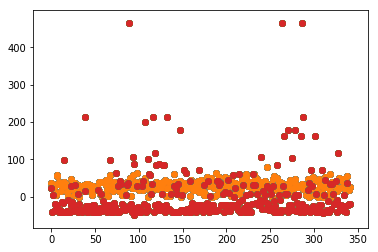

In [11]:
import numpy as np
import matplotlib.pyplot as plt
data_array=np.array(data)
Newdata_array=np.array(Newdata)
Invdata_array=np.array(Invdata)

X=[x for x in range(342)]
for i in range(342):
    plt.scatter(X,data_array[:,0])
for i in range(342):
    plt.scatter(X,Newdata_array[:,0])
#for i in range(342):
#    plt.scatter(X,Invdata_array[:,0])

因为第一个特征占所有特征的95%，所以将数据降到一维

In [10]:
pca = PCA(n_components=1)
Newdata = pca.fit_transform(data)#用数据data训练pca模型，同时返回降维后的数据
print(pca.explained_variance_ratio_)#返回所保留的n个成分各自的方差百分比

[0.95749059]
